In [2]:
# !pip install tensorflowjs
# !pip install pyforest
# !pip install --upgrade tensorflow

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import cv2
import keras
import tensorflow as tf
from pyforest import *

2024-07-16 08:30:30.217641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 08:30:30.238393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 08:30:30.244759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from tensorflow.keras.callbacks import (ModelCheckpoint,
                                        Callback,
                                        EarlyStopping,
                                        ReduceLROnPlateau)

from tensorflow.keras.layers import (InputLayer,
                                     Conv2D,
                                     SeparableConv2D,
                                     MaxPooling2D,
                                     MaxPool2D,
                                     Dense,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization)

In [5]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, classification_report
# import tensorflow as tf

# from tf.keras import models, layers
# from tf.keras.preprocessing import image
# from tf.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# from tf.keras.optimizers import Adam, RMSprop, SGD
# from tf.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
# from tf.keras.models import Sequential, Model
# from tf.keras.applications import MobileNet
# from tf.keras.applications.densenet import DenseNet121
# from tf.keras.utils import to_categorical
# from tf.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

## Dataset
Data yang digunakan dalam proyek Klasifikasi Gambar Spesies Ikan yang berisikan 40.000 gambar dengan memiliki beberapa kelas atau spesies ikan air laut dan ikan air tawar yang didapat dari:

https://www.kaggle.com/datasets/giannisgeorgiou/fish-species

In [8]:
ikan_train = Path('/kaggle/input/fish-species/Species/Training_Set')

<IPython.core.display.Javascript object>

In [38]:
rute_gambar1 = list(ikan_train.glob(r'**/*.jpg'))
label1       = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], rute_gambar1))

In [39]:
rute_gambar1 = pd.Series(rute_gambar1, name='Direktori').astype(str)
label1       = pd.Series(label1, name='label')

In [40]:
df_latih = pd.concat([rute_gambar1, label1], axis=1)

In [12]:
df_latih

,Direktori,label
0,/kaggle/input/fish-species/Species/Training_Se...,Polyprion americanus
1,/kaggle/input/fish-species/Species/Training_Se...,Polyprion americanus
2,/kaggle/input/fish-species/Species/Training_Se...,Polyprion americanus
3,/kaggle/input/fish-species/Species/Training_Se...,Polyprion americanus
4,/kaggle/input/fish-species/Species/Training_Se...,Polyprion americanus
...,...,...
33995,/kaggle/input/fish-species/Species/Training_Se...,Epinephelus caninus
33996,/kaggle/input/fish-species/Species/Training_Se...,Epinephelus caninus
33997,/kaggle/input/fish-species/Species/Training_Se...,Epinephelus caninus
33998,/kaggle/input/fish-species/Species/Training_Se...,Epinephelus caninus


In [18]:
df_latih.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34000 entries, 0 to 33999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Direktori  34000 non-null  object
 1   label      34000 non-null  object
dtypes: object(2)
memory usage: 531.4+ KB


In [37]:
pilih_ikan   = ['Solea solea',
                'Squalus acanthias',
                'Epinephelus caninus', 
                'Mugil cephalus',
                'Chlorophthalmus agassizi',
                'Dasyatis centroura']

df_latih_baru = df_latih[df_latih['label'].isin(pilih_ikan)]
df_latih_baru.reset_index(drop=True, inplace=True)

In [20]:
df_latih_baru

,Direktori,label
0,/kaggle/input/fish-species/Species/Training_Se...,Dasyatis centroura
1,/kaggle/input/fish-species/Species/Training_Se...,Dasyatis centroura
2,/kaggle/input/fish-species/Species/Training_Se...,Dasyatis centroura
3,/kaggle/input/fish-species/Species/Training_Se...,Dasyatis centroura
4,/kaggle/input/fish-species/Species/Training_Se...,Dasyatis centroura
...,...,...
10195,/kaggle/input/fish-species/Species/Training_Se...,Epinephelus caninus
10196,/kaggle/input/fish-species/Species/Training_Se...,Epinephelus caninus
10197,/kaggle/input/fish-species/Species/Training_Se...,Epinephelus caninus
10198,/kaggle/input/fish-species/Species/Training_Se...,Epinephelus caninus


In [41]:
ikan_test = Path('/kaggle/input/fish-species/Species/Test_Set')

rute_gambar2 = list(ikan_test.glob(r'**/*.jpg'))
label2       = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], rute_gambar2))

rute_gambar2 = pd.Series(rute_gambar2, name='Direktori').astype(str)
label2       = pd.Series(label2, name='label')

df_uji = pd.concat([rute_gambar2, label2], axis=1)

df_uji_baru = df_uji[df_uji['label'].isin(pilih_ikan)]
df_uji_baru.reset_index(drop=True, inplace=True)

In [22]:
df_uji_baru

,Direktori,label
0,/kaggle/input/fish-species/Species/Test_Set/Da...,Dasyatis centroura
1,/kaggle/input/fish-species/Species/Test_Set/Da...,Dasyatis centroura
2,/kaggle/input/fish-species/Species/Test_Set/Da...,Dasyatis centroura
3,/kaggle/input/fish-species/Species/Test_Set/Da...,Dasyatis centroura
4,/kaggle/input/fish-species/Species/Test_Set/Da...,Dasyatis centroura
...,...,...
1795,/kaggle/input/fish-species/Species/Test_Set/Ep...,Epinephelus caninus
1796,/kaggle/input/fish-species/Species/Test_Set/Ep...,Epinephelus caninus
1797,/kaggle/input/fish-species/Species/Test_Set/Ep...,Epinephelus caninus
1798,/kaggle/input/fish-species/Species/Test_Set/Ep...,Epinephelus caninus


In [6]:
df_ikan = pd.concat([df_latih_baru, df_uji_baru], ignore_index=True)
# df_ikan = pd.read_csv('/kaggle/input/klasifikasi-ikan-roni/df_ikan.csv')

<IPython.core.display.Javascript object>

In [7]:
df_ikan['label'].value_counts()

label
Dasyatis centroura          2000
Solea solea                 2000
Chlorophthalmus agassizi    2000
Squalus acanthias           2000
Mugil cephalus              2000
Epinephelus caninus         2000
Name: count, dtype: int64

In [8]:
df_ikan.duplicated().sum()

0

In [27]:
df_ikan.isnull().sum()

Direktori    0
label        0
dtype: int64

In [28]:
df_ikan.dtypes

Direktori    object
label        object
dtype: object

In [9]:
df_ikan

,Direktori,label
0,/kaggle/input/fish-species/Species/Training_Se...,Dasyatis centroura
1,/kaggle/input/fish-species/Species/Training_Se...,Dasyatis centroura
2,/kaggle/input/fish-species/Species/Training_Se...,Dasyatis centroura
3,/kaggle/input/fish-species/Species/Training_Se...,Dasyatis centroura
4,/kaggle/input/fish-species/Species/Training_Se...,Dasyatis centroura
...,...,...
11995,/kaggle/input/fish-species/Species/Test_Set/Ep...,Epinephelus caninus
11996,/kaggle/input/fish-species/Species/Test_Set/Ep...,Epinephelus caninus
11997,/kaggle/input/fish-species/Species/Test_Set/Ep...,Epinephelus caninus
11998,/kaggle/input/fish-species/Species/Test_Set/Ep...,Epinephelus caninus


### Splitting Data

In [10]:
df_train, df_test = train_test_split(df_ikan, test_size=0.2, shuffle=True, random_state=1)

In [11]:
df_train.shape

(9600, 2)

In [12]:
df_test.shape

(2400, 2)

#### Dataset sepertinya memiliki resolusi yang tidak seragam

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

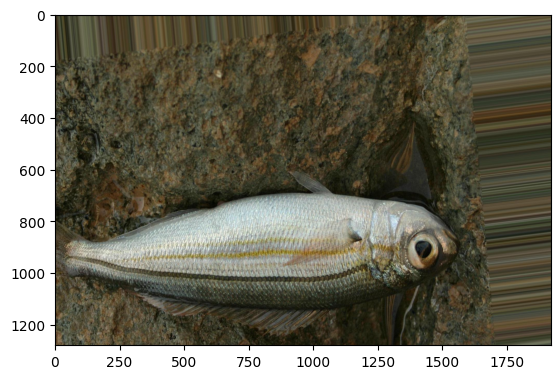

In [51]:
plt.imshow(image.load_img(np.random.choice(rute_gambar1)))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

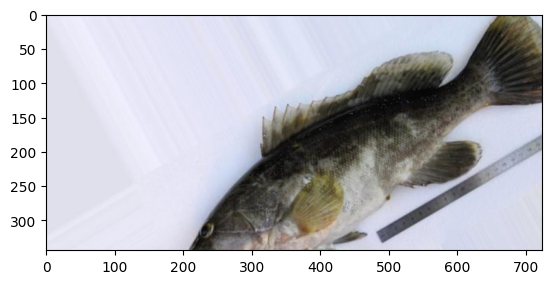

In [57]:
plt.imshow(image.load_img(np.random.choice(rute_gambar1)))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

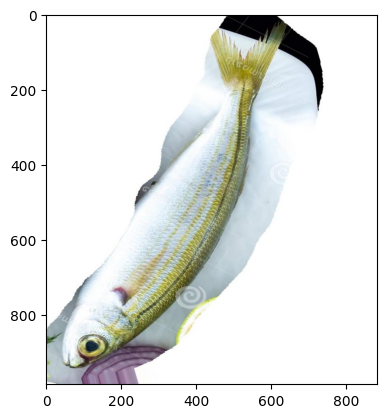

In [58]:
plt.imshow(image.load_img(np.random.choice(rute_gambar2)))

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
df_ikan.columns

Index(['Direktori', 'label'], dtype='object')

In [16]:
batch_sizeku = 128
epochs = 10

In [17]:
# train images
gambar_latih = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                 x_col='Direktori',
                                                 y_col='label',
                                                 target_size=(255, 255),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=batch_sizeku,
                                                 shuffle=True,
                                                 seed=42,
                                                 subset='training')

# validation images
gambar_valid = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                 x_col='Direktori',
                                                 y_col='label',
                                                 target_size=(255, 255),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=batch_sizeku,
                                                 shuffle=True,
                                                 seed=42,
                                                 subset='validation')

# test images
gambar_tests = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                x_col='Direktori',
                                                y_col='label',
                                                target_size=(255, 255),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=batch_sizeku,
                                                shuffle=True)

Found 7680 validated image filenames belonging to 6 classes.
Found 1920 validated image filenames belonging to 6 classes.
Found 2400 validated image filenames belonging to 6 classes.


In [18]:
gambar_tests.class_indices

{'Chlorophthalmus agassizi': 0,
 'Dasyatis centroura': 1,
 'Epinephelus caninus': 2,
 'Mugil cephalus': 3,
 'Solea solea': 4,
 'Squalus acanthias': 5}

In [29]:
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(255, 255, 3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(6, activation='softmax'))

model2.compile(optimizer=Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [30]:
early_stopping2 = EarlyStopping(monitor='val_loss',
                                patience=5,
                                restore_best_weights=True)

In [ ]:
latih2 = model2.fit(gambar_latih,
                    epochs=epochs,
                    callbacks=[early_stopping2],
                    validation_data=gambar_valid)

Epoch 1/10


E0000 00:00:1721121345.800913     304 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1721121346.032305     304 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-07-16 09:15:52.198191: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng21{k2=2,k4=3,k5=0,k6=0,k7=0} for conv (f32[128,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,126,126]{3,2,1,0}, f32[128,128,124,124]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024

60/60 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.3573 - loss: 13.5827 - val_accuracy: 0.1771 - val_loss: 10.8157
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.4494 - loss: 1.5431 - val_accuracy: 0.1771 - val_loss: 25.1843
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.4751 - loss: 1.3556 - val_accuracy: 0.1771 - val_loss: 32.0712
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.4636 - loss: 1.3286 - val_accuracy: 0.1776 - val_loss: 40.7941
Epoch 5/10
24/60 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.4981 - loss: 1.2937

In [ ]:
plt.plot(latih1.history['loss'], label='train loss')
if 'val_loss' in latih1.history:
    plt.plot(latih1.history['val_loss'], label='val loss')
plt.legend();

In [ ]:
plt.plot(latih1.history['accuracy'], label='train acc')
if 'val_accuracy' in latih1.history:
    plt.plot(latih1.history['val_accuracy'], label='val acc')
plt.legend();

In [ ]:
hasil = model1.evaluate(gambar_tests, verbose=0)

print("    Test Loss: {:.5f}".format(hasil[0]))
print("Test Accuracy: {:.2f}%".format(hasil[1] * 100))

### Save Model TF Lite:
- Save to SavedModel = .save()
- Convert to vegs.tflite

### Save Model TFJS:
- Save to H5 first
- Convert to tfjs

In [6]:
# model.save("model.h5")

# # Install tensorflowjs
# !pip install tensorflowjs
 
# # Convert model.h5 to model
# !tensorflowjs_converter --input_format=keras model.h5 tfjs_model

In [7]:
# # Menyimpan model dalam format SavedModel
# export_dir = 'saved_model/'
# tf.saved_model.save(model, export_dir)
 
# # Convert SavedModel menjadi vegs.tflite
# converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
# tflite_model = converter.convert()
 
# tflite_model_file = pathlib.Path('vegs.tflite')
# tflite_model_file.write_bytes(tflite_model)